# Tumor Detection and Diagnosis




##  Overview
This project focuses on **detecting brain tumors** from MRI images using **YOLO (You Only Look Once)** — one of the fastest and most accurate object detection architectures.  
The model was trained on a custom dataset containing multiple types of brain tumors and then deployed as an interactive **Streamlit web app** for easy visualization.

---

##  Project Objectives
- Build an automated detection system for brain tumors from MRI scans.
- Train a YOLO model on custom medical image data.
- Evaluate the model’s performance using key metrics (Precision, Recall, mAP).
- Deploy an easy-to-use Streamlit web app for real-time predictions.

---

##  Dataset
The dataset was obtained from **[Roboflow](https://roboflow.com/)** and includes MRI brain scan images categorized into four main classes:

| Class | Description |
|--------|--------------|
| Glioma | Tumor originating in glial cells |
| Meningioma | Tumor of the meninges (brain membranes) |
| Pituitary | Tumor in the pituitary gland |
| No-Tumor | Normal MRI (no tumor) |

The dataset was split into:
- **Training set**
- **Validation set**
- **Testing set**

A visualization and analysis of the dataset were performed to ensure balanced class distribution and verify annotation quality.

---

##  Project Workflow

### 1️ Data Preparation
- Imported the dataset from Roboflow.
- Verified the structure:  
  `train/`, `valid/`, and `test/` folders each containing `images/` and `labels/`.
- Analyzed and visualized class distribution.

### 2️ Model Training
- Used **Ultralytics YOLO** framework.
- Configuration example:
  ```python
  from ultralytics import YOLO
  model = YOLO('yolov11n.pt')  # Pretrained YOLO model
  model.train(data='data.yaml', epochs=50, imgsz=640)


## 1. Import Helper libraries

In [14]:
import cv2 
import os
import yaml
import random
import pandas as ps 
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from ultralytics import YOLO
from roboflow import Roboflow

## 2. Get the data from `Roboflow` and start working

In [6]:
rf = Roboflow(api_key="a4rwhxCCpgY5AzqRMCax")
project = rf.workspace("yousef-abdelsalam-vcbzv").project("tumer-wroso-abvq7")
version = project.version(1)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Tumer-1 in yolov11:: 100%|██████████| 7844/7844 [00:01<00:00, 7296.87it/s]


## 3. Make the visualization of the data

In [9]:
labels_dir = "/kaggle/working/Tumer-1/train/labels"

100%|██████████| 3423/3423 [00:00<00:00, 30395.57it/s]


 عدد العينات في كل Class:
   class_id  count
3         0    852
2         1    891
0         2    894
1         3    870


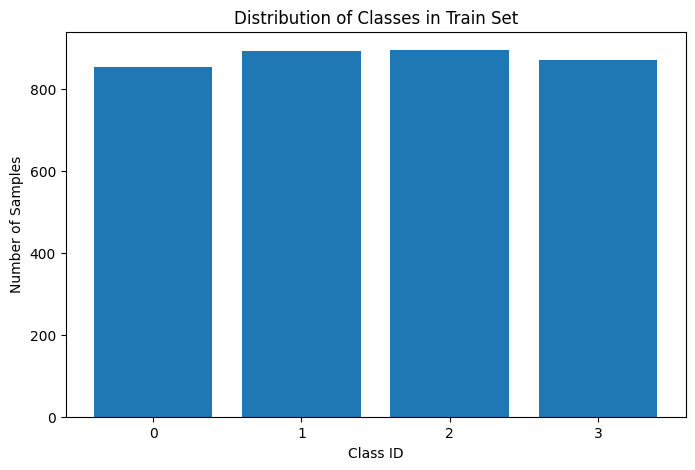

In [10]:
class_counts = Counter()

for label_file in tqdm(os.listdir(labels_dir)):
    if label_file.endswith(".txt"):
        with open(os.path.join(labels_dir, label_file), "r") as f:
            for line in f:
                class_id = int(line.strip().split()[0])
                class_counts[class_id] += 1

df = pd.DataFrame(list(class_counts.items()), columns=["class_id", "count"])
df = df.sort_values("class_id")

print(" عدد العينات في كل Class:")
print(df)

# رسم بياني
plt.figure(figsize=(8,5))
plt.bar(df["class_id"], df["count"])
plt.xlabel("Class ID")
plt.ylabel("Number of Samples")
plt.title("Distribution of Classes in Train Set")
plt.xticks(df["class_id"])
plt.show()

🧾 Class names:
0: Glioma
1: Meningioma
2: No-Tumor
3: Pituitary


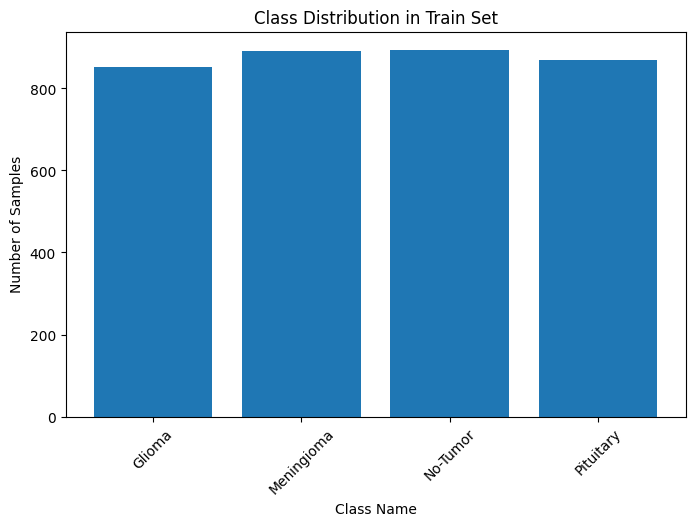

In [12]:
with open("/kaggle/working/Tumer-1/data.yaml", "r") as f:
    data_yaml = yaml.safe_load(f)

names = data_yaml.get("names", [])
print("🧾 Class names:")
for i, name in enumerate(names):
    print(f"{i}: {name}")

df["class_name"] = df["class_id"].apply(lambda x: names[x] if x < len(names) else f"Class {x}")

plt.figure(figsize=(8,5))
plt.bar(df["class_name"], df["count"])
plt.xlabel("Class Name")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Train Set")
plt.xticks(rotation=45)
plt.show()

## 4. Make the visualiztion of the sample data

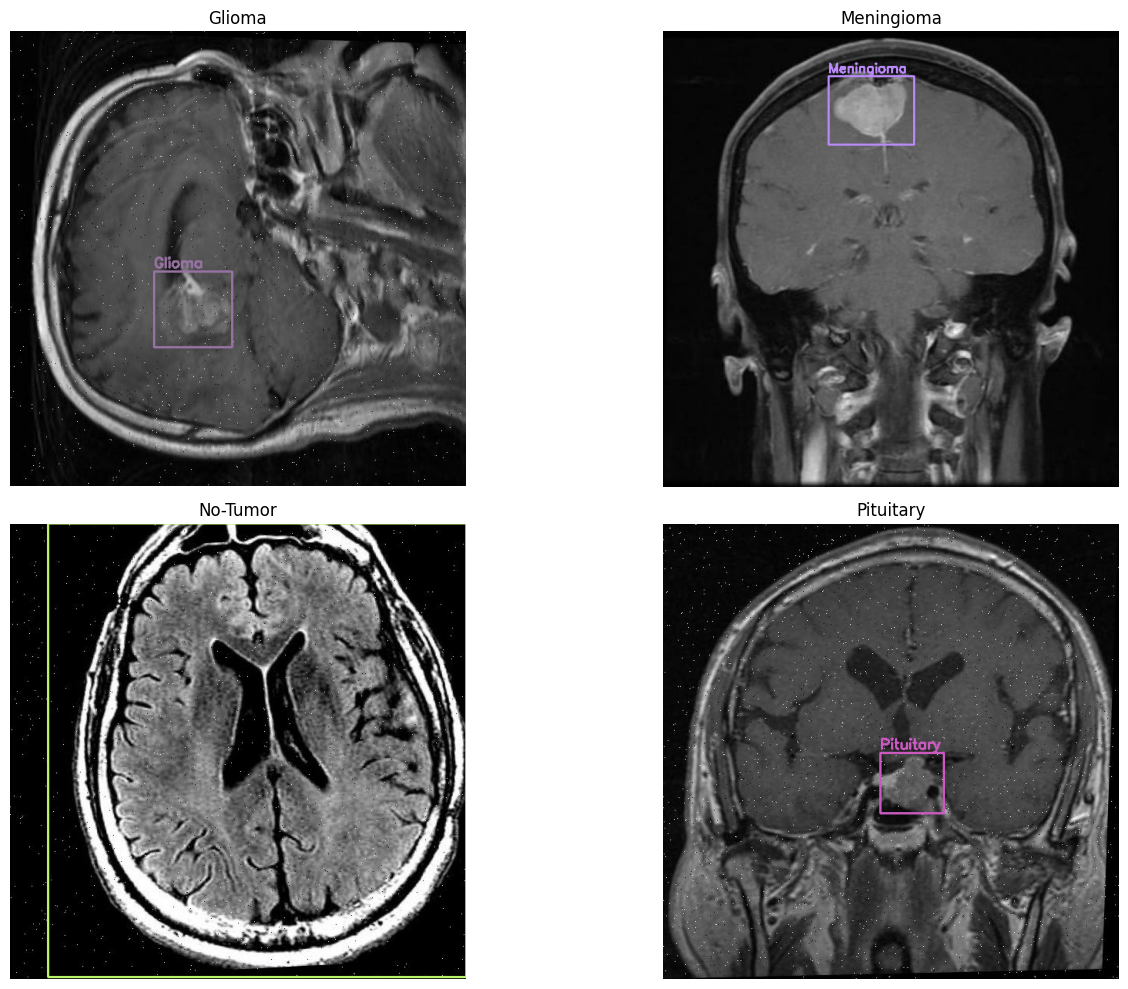

In [15]:
base_dir = "/kaggle/working/Tumer-1/train"
images_dir = os.path.join(base_dir, "images")
labels_dir = os.path.join(base_dir, "labels")

with open("/kaggle/working/Tumer-1/data.yaml", "r") as f:
    data_yaml = yaml.safe_load(f)
class_names = data_yaml.get("names", [])

def plot_image_with_boxes(img_path, label_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    if not os.path.exists(label_path):
        return img

    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            cls_id, x_center, y_center, bw, bh = map(float, parts[:5])
            cls_id = int(cls_id)
            
            x_center, y_center, bw, bh = x_center * w, y_center * h, bw * w, bh * h
            x1, y1 = int(x_center - bw / 2), int(y_center - bh / 2)
            x2, y2 = int(x_center + bw / 2), int(y_center + bh / 2)

            color = (random.randint(0,255), random.randint(0,255), random.randint(0,255))
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
            label = class_names[cls_id] if cls_id < len(class_names) else str(cls_id)
            cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    return img

shown_classes = set()

plt.figure(figsize=(15, 10))

for img_file in os.listdir(images_dir):
    if len(shown_classes) == len(class_names):
        break

    img_name = os.path.splitext(img_file)[0]
    label_file = os.path.join(labels_dir, f"{img_name}.txt")

    if not os.path.exists(label_file):
        continue

    with open(label_file, "r") as f:
        for line in f:
            cls_id = int(line.strip().split()[0])
            if cls_id not in shown_classes:
                img_path = os.path.join(images_dir, img_file)
                img = plot_image_with_boxes(img_path, label_file)

                plt.subplot(2, (len(class_names)+1)//2, cls_id + 1)
                plt.imshow(img)
                plt.title(class_names[cls_id] if cls_id < len(class_names) else f"Class {cls_id}")
                plt.axis("off")

                shown_classes.add(cls_id)
                break

plt.tight_layout()
plt.show()


## 5. Make the comparison of the `train` , `valid` and `test` data  

📊 مقارنة عدد العينات لكل Class في كل Split:
split       test  train  valid   Total
class_name                            
Glioma      43.0  852.0   92.0   987.0
Meningioma  42.0  891.0   73.0  1006.0
No-Tumor    47.0  894.0   79.0  1020.0
Pituitary   38.0  870.0  102.0  1010.0


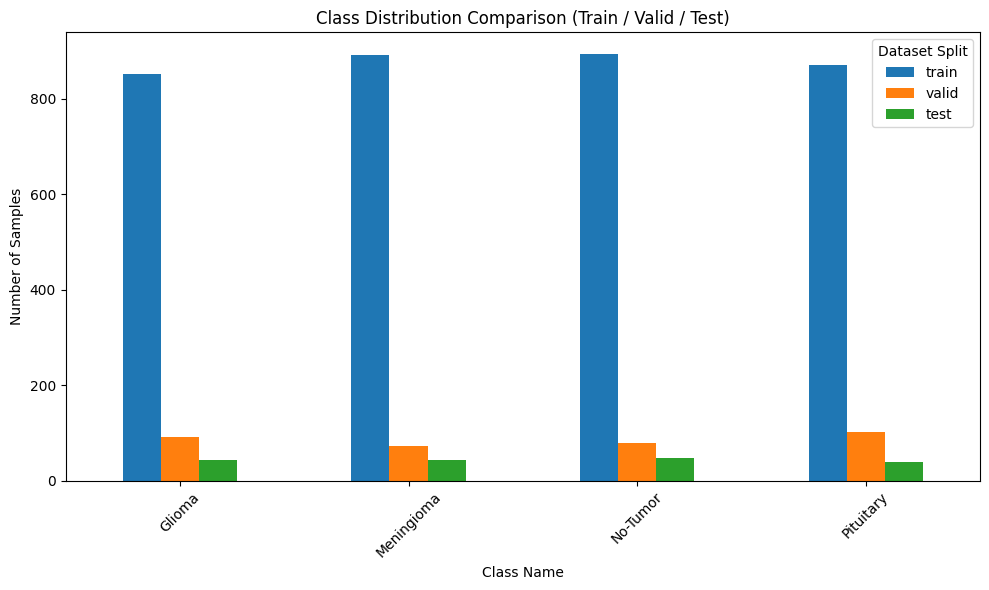

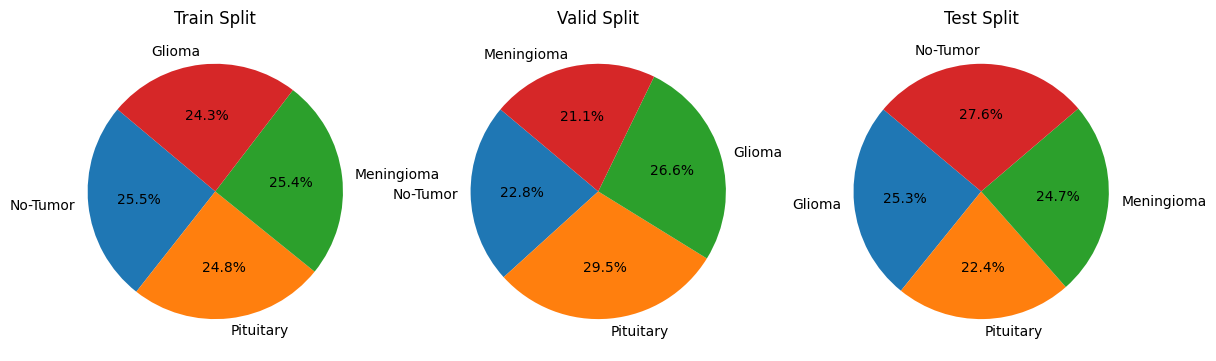

In [17]:
base_dir = "/kaggle/working/Tumer-1"  
splits = ["train", "valid", "test"]  

with open(os.path.join(base_dir, "/kaggle/working/Tumer-1/data.yaml"), "r") as f:
    data_yaml = yaml.safe_load(f)
class_names = data_yaml.get("names", [])
num_classes = len(class_names)

def count_classes_in_split(split_name):
    labels_dir = os.path.join(base_dir, split_name, "labels")
    class_counts = Counter()

    if not os.path.exists(labels_dir):
        print(f"⚠️ Warning: {split_name} folder not found!")
        return pd.DataFrame(columns=["class_id", "count"])

    for label_file in os.listdir(labels_dir):
        if label_file.endswith(".txt"):
            with open(os.path.join(labels_dir, label_file), "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 1:
                        cls_id = int(parts[0])
                        class_counts[cls_id] += 1

    df = pd.DataFrame(list(class_counts.items()), columns=["class_id", "count"])
    df["split"] = split_name
    return df

dfs = []
for split in splits:
    dfs.append(count_classes_in_split(split))

all_df = pd.concat(dfs, ignore_index=True)

all_df["class_name"] = all_df["class_id"].apply(lambda x: class_names[x] if x < len(class_names) else f"Class {x}")

comparison = all_df.pivot_table(index="class_name", columns="split", values="count", fill_value=0)
comparison["Total"] = comparison.sum(axis=1)

print("📊 مقارنة عدد العينات لكل Class في كل Split:")
print(comparison)

comparison[splits].plot(kind="bar", figsize=(10,6))
plt.title("Class Distribution Comparison (Train / Valid / Test)")
plt.xlabel("Class Name")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.legend(title="Dataset Split")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, len(splits), figsize=(14,5))
for i, split in enumerate(splits):
    df_split = all_df[all_df["split"] == split]
    axes[i].pie(df_split["count"], labels=df_split["class_name"], autopct='%1.1f%%', startangle=140)
    axes[i].set_title(f"{split.capitalize()} Split")
plt.show()


## 6. Get The `YOLO11` modle and make training 

In [19]:
model = YOLO('yolo11n.pt')

In [22]:
model.train(data = '/kaggle/working/Tumer-1/data.yaml' , epochs = 50 , batch = 15)

Ultralytics 8.3.205 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=15, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/Tumer-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, p

invalid value encountered in less
invalid value encountered in less


                   all        326        346      0.904      0.875      0.912      0.655
                Glioma         81         92      0.823      0.728      0.796      0.473
            Meningioma         71         73      0.984      0.859      0.948      0.661
              No-Tumor         79         79      0.957          1      0.982       0.95
             Pituitary         95        102      0.852      0.912       0.92      0.537
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to /kaggle/working/runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f19dc3a0450>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

## 7. Evaluates the trained YOLO model on the test dataset

In [27]:
model = YOLO("/kaggle/working/runs/detect/train/weights/best.pt")

metrics = model.val(data="/kaggle/working/Tumer-1/data.yaml", split="test")

print(metrics)

Ultralytics 8.3.205 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 672.1±282.5 MB/s, size: 30.3 KB)
val: Scanning /kaggle/working/Tumer-1/test/labels... 167 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 167/167 1.3Kit/s 0.1s<0.1s
val: New cache created: /kaggle/working/Tumer-1/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 11/11 3.8it/s 2.9s0.1s


invalid value encountered in less
invalid value encountered in less


                   all        167        170      0.902      0.895      0.935      0.666
                Glioma         40         43      0.856      0.827      0.893      0.512
            Meningioma         42         42      0.974      0.885      0.968      0.675
              No-Tumor         47         47      0.975          1      0.994      0.967
             Pituitary         38         38      0.805       0.87      0.886       0.51
Speed: 2.1ms preprocess, 6.2ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to /kaggle/working/runs/detect/val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f19dc3c5450>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,  

## 8. Make the test of the data and check the result of the detection model 


image 1/1 /kaggle/working/Tumer-1/test/images/Tr-gl_1193_jpg.rf.e3f24ae41e96b12f1a453afed46b031e.jpg: 640x640 1 Glioma, 9.1ms
Speed: 1.7ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


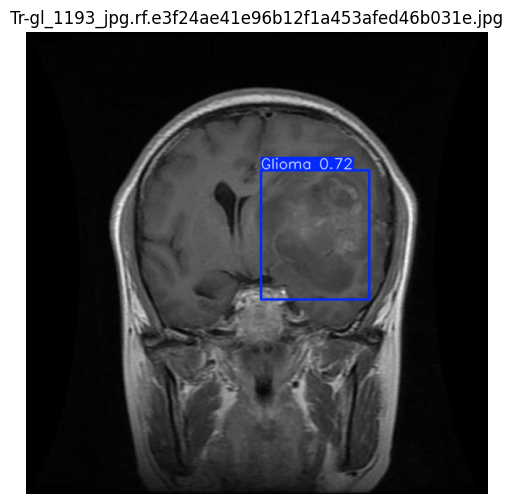


image 1/1 /kaggle/working/Tumer-1/test/images/Tr-gl_0794_jpg.rf.cddfebdc278a130c360608b57dfb0a64.jpg: 640x640 1 Glioma, 10.1ms
Speed: 1.8ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


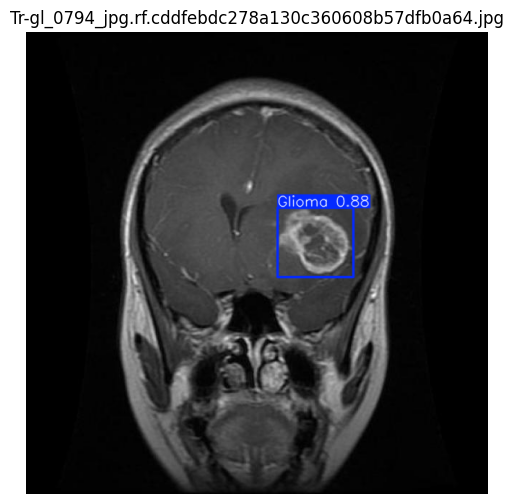


image 1/1 /kaggle/working/Tumer-1/test/images/Tr-no_0284_jpg.rf.4f0d33554be720743fe8efe6d2ae197d.jpg: 640x640 1 No-Tumor, 10.0ms
Speed: 1.6ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


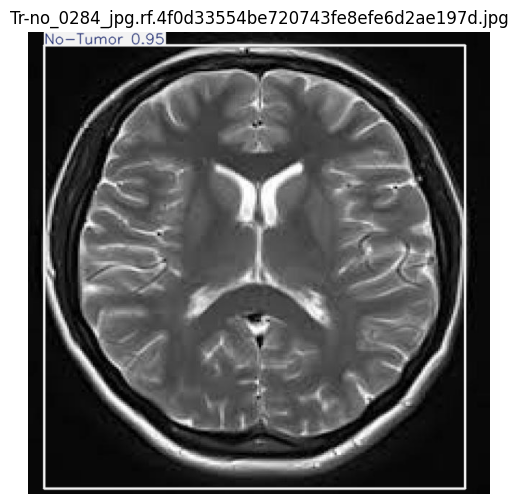


image 1/1 /kaggle/working/Tumer-1/test/images/Tr-pi_0709_jpg.rf.0ac58439be0e4cdfaba0a054473fa00a.jpg: 640x640 1 Pituitary, 9.8ms
Speed: 1.6ms preprocess, 9.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


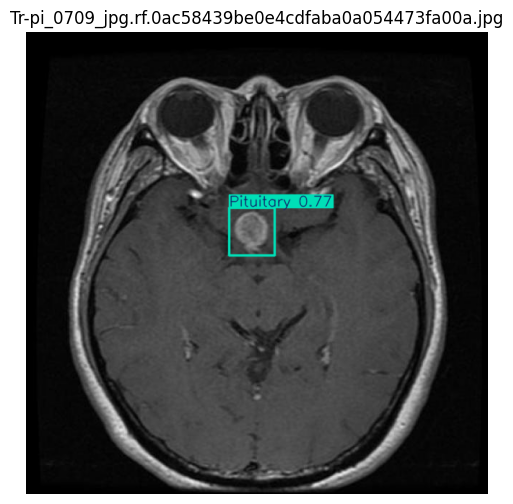


image 1/1 /kaggle/working/Tumer-1/test/images/Tr-no_1000_jpg.rf.54b555eb3b1ed2c14fe1b58ba13decdb.jpg: 640x640 1 No-Tumor, 10.2ms
Speed: 2.0ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


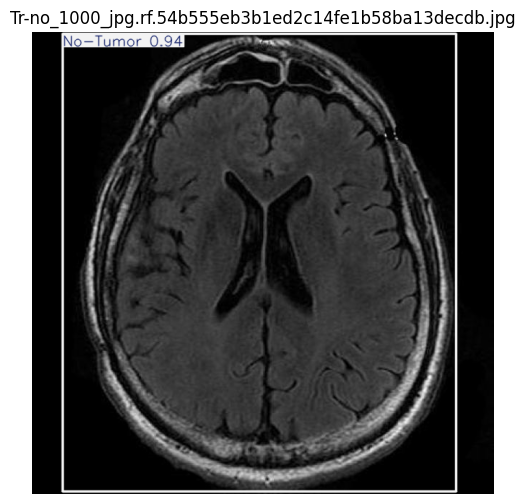

In [30]:
model_path = "/kaggle/working/runs/detect/train/weights/best.pt"  
model = YOLO(model_path)

test_dir = "/kaggle/working/Tumer-1/test/images"

num_samples = 5  
all_images = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
sample_images = random.sample(all_images, min(num_samples, len(all_images)))

for img_path in sample_images:
    results = model.predict(source=img_path, conf=0.25)  
    res_img = results[0].plot()  
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(res_img, cv2.COLOR_BGR2RGB))
    plt.title(os.path.basename(img_path))
    plt.axis("off")
    plt.show()

## 9. Save The Model

In [ ]:
model = YOLO("runs/detect/train/weights/best.pt")

model.export(format='pt', name='brain_tumor_model')

# Thanks